# BLM example

In [1]:
# Add PyTwoWay to system path (SET THESE TO WHERE YOU HAVE THE PACKAGE REPOSITORIES CLONED)
import sys
sys.path.append('../../..')
sys.path.append('../../../../bipartitepandas')

In [2]:
# Import the PyTwoWay package 
# (Make sure you have installed it using pip install pytwoway)
import bipartitepandas as bpd
import pytwoway as tw
from matplotlib import pyplot as plt

## First, check out parameter options

In [3]:
print('----- BLM -----')
tw.blm_params().describe_all()
print('----- Clustering -----')
bpd.cluster_params().describe_all()
print('----- Cleaning -----')
bpd.clean_params().describe_all()
print('----- Simulation -----')
bpd.sim_params().describe_all()

----- BLM -----
KEY: 'nl'
CURRENT VALUE: 6
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=6) Number of worker types.
        
KEY: 'nk'
CURRENT VALUE: 10
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=10) Number of firm types.
        
KEY: 'fixb'
CURRENT VALUE: False
VALID VALUES: one of type <class 'bool'>
DESCRIPTION: 
            (default=False) If True, set A2 = np.mean(A2, axis=0) + A1 - np.mean(A1, axis=0).
        
KEY: 'stationary'
CURRENT VALUE: False
VALID VALUES: one of type <class 'bool'>
DESCRIPTION: 
            (default=False) If True, set A1 = A2.
        
KEY: 'simulation'
CURRENT VALUE: False
VALID VALUES: one of type <class 'bool'>
DESCRIPTION: 
            (default=False) If True, using model to simulate data.
        
KEY: 'n_iters'
CURRENT VALUE: 100
VALID VALUES: one of type <class 'int'>
CONSTRAINTS: '>= 1'
DESCRIPTION: 
            (default=100) Number of iterations

## Second, set parameter choices

In [4]:
nl = 2 # Number of worker types
nk = 3 # Number of firm types
blm_params = tw.blm_params({'nl': nl, 'nk': nk, 'fixb': False, 'stationary': False, 'n_iters': 100, 'threshold': 1e-7, 'd_prior': 1.0001, 'verbose': 0})
cluster_params = bpd.cluster_params({'measures': bpd.measures.cdfs(), 'grouping': bpd.grouping.kmeans(n_clusters=nk), 'is_sorted': True, 'copy': False})
clean_params = bpd.clean_params({'drop_returns': 'returners', 'copy': False})
sim_params = bpd.sim_params({'nl': nl, 'nk': nk})

## Simulate data

Simulate a bipartite network using BipartitePandas. We use this here to demonstrate how to fit the estimator using real data.

In [5]:
sim_data = bpd.BipartiteLong(bpd.SimBipartite(sim_params).sim_network()).clean_data(clean_params).cluster(cluster_params).get_collapsed_long(is_sorted=True, copy=False).get_es(is_sorted=True, copy=False)
print('Movers data')
display(sim_data[sim_data['m'] > 0])
print('Stayers data')
display(sim_data[sim_data['m'] == 0])

Movers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,g1,g2,w1,w2,m
0,0,157,90,-0.966646,-1.577025,0,0,1,1,0,2,1,1,1
1,0,90,174,-1.577025,0.545599,1,1,2,2,2,0,1,1,1
2,0,174,154,0.545599,1.120893,2,2,3,3,0,0,1,1,1
3,0,154,80,1.120893,-1.997402,3,3,4,4,0,2,1,1,1
4,1,90,49,0.720153,-0.786352,0,0,1,2,2,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20417,9915,5,63,-1.245764,0.474493,1,1,2,2,1,1,1,1,1
20418,9915,63,48,0.474493,-0.796377,2,2,3,4,1,1,1,2,1
20419,9916,175,157,0.551150,1.408641,0,1,2,4,0,0,2,3,1
20420,9917,72,28,0.281480,-0.783105,0,1,2,3,2,1,2,2,1


Stayers data


,i,j1,j2,y1,y2,t11,t12,t21,t22,g1,g2,w1,w2,m
47,19,184,184,-0.054934,-0.054934,0,4,0,4,0,0,5,5,0
134,60,75,75,0.087411,0.087411,0,4,0,4,2,2,5,5,0
148,68,97,97,-0.328443,-0.328443,0,4,0,4,2,2,5,5,0
169,77,50,50,-1.541922,-1.541922,0,4,0,4,1,1,5,5,0
210,97,45,45,-0.485300,-0.485300,0,4,0,4,1,1,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20251,9836,20,20,-1.470377,-1.470377,0,4,0,4,1,1,5,5,0
20277,9849,61,61,-0.890328,-0.890328,0,4,0,4,1,1,5,5,0
20329,9874,188,188,1.083919,1.083919,0,4,0,4,0,0,5,5,0
20386,9901,168,168,0.698421,0.698421,0,4,0,4,0,0,5,5,0


## Initialize and run BLMEstimator

In [6]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=sim_data[sim_data['m'] > 0], sdata=sim_data[sim_data['m'] == 0], n_init=40, n_best=5, ncore=4)

100%|███████████████████████████████████████████| 40/40 [00:31<00:00,  1.29it/s]


## Finally, we can investigate the results

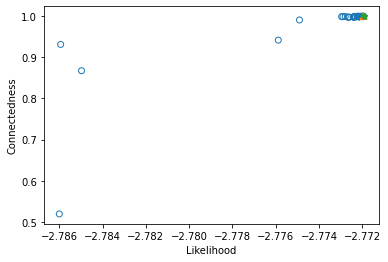

In [7]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

# Measuring the Model's Effectiveness

## Simulate some data

The package contains functions to simulate data. We use this here to compare model estimates to true parameter values.

## Set parameter choices

In [8]:
blm_sim_params = tw.blm_params({'nl': nl, 'nk': nk, 'simulation': True})

## Simulate data

In [9]:
blm_true = tw.BLMModel(blm_sim_params)
sim_data = blm_true._m2_mixt_simulate_sim(
    fsize=10, # Average number of stayers per firm
    mmult=100, # Increase observations for movers x100
    smult=100 # Increase observations for stayers x100
)

In [10]:
print('Movers data')
display(sim_data['jdata'])
print('Stayers data')
display(sim_data['sdata'])

Movers data


,y1,y2,j1,j2,g1,g2
0,0.707916,0.602713,60,97,0,0
1,0.590862,0.414513,48,76,0,0
2,0.273032,-0.405754,67,12,0,0
3,0.891509,0.995318,93,68,0,0
4,0.204610,-0.265502,4,13,0,0
...,...,...,...,...,...,...
8995,1.080566,1.862252,204,224,2,2
8996,1.826479,0.798927,289,215,2,2
8997,1.823436,1.065808,222,224,2,2
8998,1.879740,2.310461,286,286,2,2


Stayers data


,y1,y2,j1,j2,g1,g2
0,0.148868,1.513912,46,46,0,0
1,1.503992,1.231494,28,28,0,0
2,0.421466,0.019523,14,14,0,0
3,0.565448,1.624662,54,54,0,0
4,-0.397976,-0.018779,7,7,0,0
...,...,...,...,...,...,...
2995,1.446281,1.745013,239,239,2,2
2996,1.591212,0.733592,224,224,2,2
2997,1.358259,1.381509,264,264,2,2
2998,1.100254,1.376311,244,244,2,2


## Initialize and run BLMEstimator

In [11]:
# Initialize BLM estimator
blm_fit = tw.BLMEstimator(blm_params)
# Fit BLM estimator
blm_fit.fit(jdata=sim_data['jdata'], sdata=sim_data['sdata'], n_init=40, n_best=5, ncore=4)

100%|███████████████████████████████████████████| 40/40 [00:12<00:00,  3.18it/s]


## Finally, compare truth to estimates

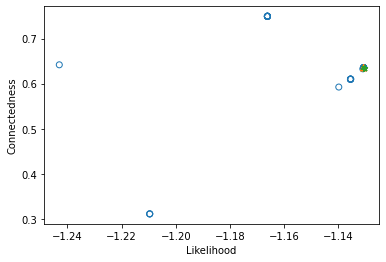

In [12]:
# Plot likelihood vs. connectedness
blm_fit.plot_liks_connectedness()

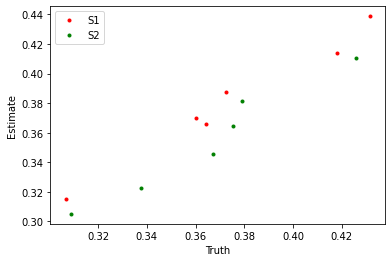

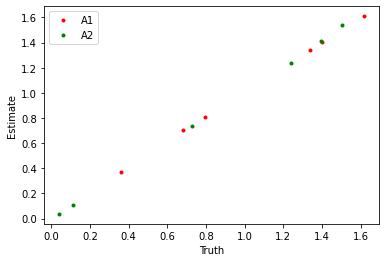

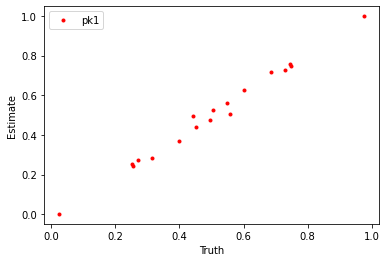

In [13]:
# Plot parameter truth vs. estimates
plt.plot(blm_true.S1.flatten(), blm_fit.model.S1.flatten(), '.', label='S1', color='red')
plt.plot(blm_true.S2.flatten(), blm_fit.model.S2.flatten(), '.', label='S2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.show()

plt.plot(blm_true.A1.flatten(), blm_fit.model.A1.flatten(), '.', label='A1', color='red')
plt.plot(blm_true.A2.flatten(), blm_fit.model.A2.flatten(), '.', label='A2', color='green')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.show()

plt.plot(blm_true.pk1.flatten(), blm_fit.model.pk1.flatten(), '.', label='pk1', color='red')
plt.xlabel('Truth')
plt.ylabel('Estimate')
plt.legend()
plt.show()